In [14]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.models import *
from keras.layers import *
from tensorflow.keras.applications import vgg16, inception_v3, resnet50
import segmentation_models as sm
import matplotlib.pyplot as plt
import os

In [15]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [16]:
from keras.applications import vgg16
BACKBONE = 'vgg16'

# Model with the first 7 layers unlocked
size = 224
base_model = vgg16.VGG16(
    weights='imagenet',  # Load the pretrained weights, trained on the ImageNet dataset.
    include_top=False,  # We don't include the fully-connected layer at the top of the network - we need to modify the top.
    input_shape=(size, size, 3),  # 224x224 was the original size ResNet was trained on, so I decided to use this.
    pooling='max',  # A global average pooling layer will be added after the last convolutional block.
)

In [17]:
model = Sequential()

In [18]:
# Here we change the top (the last parts) of the network.
x = base_model.output  # Since we used pooling='avg', the output is of the pooling layer
x = Dropout(0.1)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(1, activation='linear')(x)  # This is the new output layer - notice only 1 output, this will correspond to the number of people in the image

model = Model(inputs=base_model.input, outputs=predictions)

In [19]:
k = -7
for layer in model.layers[:k]:
    layer.trainable = False
print('Trainable:')
for layer in model.layers[k:]:
    print(layer.name)
    layer.trainable = True

Trainable:
block5_conv3
block5_pool
global_max_pooling2d_1
dropout_1
flatten_1
dense_2
dense_3


In [20]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [21]:
import datetime
!rm -rf ./logs/
!mkdir '/content/logs'


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

'rm' is not recognized as an internal or external command,
operable program or batch file.
The syntax of the command is incorrect.


In [22]:
from keras.preprocessing import image

In [23]:
def modeling(classify):

    print(classify)

    
    # Compile the model
    model.compile(
        optimizer= 'adam', 
        loss="mean_squared_error",  # This is a classic regression score - the lower the better
        metrics=['mean_absolute_error', 'mean_squared_error']
    )

    train_datagen=image.ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, 
                                            shear_range=0.2, zoom_range=0.3, horizontal_flip=True, rescale=1/255)
    #rescale is very important to normalise the data to a small range

    val_datagen=image.ImageDataGenerator(rescale=1/255)
    #validation data doesnt need to be augmented

    train_generator=train_datagen.flow_from_directory("E:/NUS Project/Split data/train",target_size=(224,224),
                                                        batch_size=16, classes=[classify,"No Finding"])
    #size determines the dimensions of the generated pics

    print(train_generator.class_indices)

    imgs, labels = next(train_generator)

    plt.imshow(imgs[1])
    labels[1]


    val_generator=val_datagen.flow_from_directory("E:/NUS Project/Split data/val",target_size=(224,224),
                                                    batch_size=16, classes=[classify,"No Finding"])
    print(val_generator.class_indices)


    # Fit the model
    hist = model.fit(
        train_generator,
        batch_size=16,
        epochs=20,
        validation_data=val_generator,
        callbacks=[tensorboard_callback]
    )
    print('\nDone.')


    model_history=hist.history

    plt.plot(model_history['accuracy'], label='accuracy')
    plt.plot(model_history['val_accuracy'], label='val accuracy')
    plt.legend()

    plt.plot(model_history['loss'], label='loss')
    plt.plot(model_history['val_loss'], label='val loss')
    plt.legend()

    model.evaluate(val_generator)

In [24]:
import os 
my_list = os.listdir('E:/NUS Project/Split data/val')

In [25]:
#for disease in my_list:
    #modeling(disease)

Pneumonia
Found 43253 images belonging to 2 classes.
{'Pneumonia': 0, 'No Finding': 1}
Found 18539 images belonging to 2 classes.
{'Pneumonia': 0, 'No Finding': 1}
Epoch 1/20


KeyboardInterrupt: 

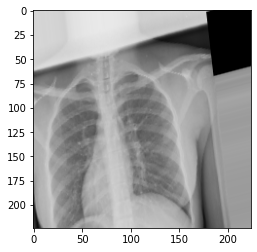

In [26]:
modeling("Pneumonia")